In [1]:
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing

# คอลัมน์ เป็น Data  ที่ EDA มาแล้ว

- MedInc — รายได้ครัวเรือนเฉลี่ย

- HouseAge — อายุบ้านเฉลี่ย

- AveRooms — จำนวนห้องเฉลี่ยต่อครัวเรือน

- AveBedrms — จำนวนห้องนอนเฉลี่ยต่อครัวเรือน

- Population — ประชากรรวม

- AveOccup — จำนวนคนเฉลี่ยต่อครัวเรือน

- Latitude — ละติจูด

- Longitude — ลองจิจูด

- MedHouseVal — target

In [3]:
data = fetch_california_housing(as_frame=False)
df = pd.DataFrame(data.data, columns=data.feature_names)
display(df.head(10))

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25


# Load Dataset (Regression) & Split ตั้งใจให้ Overfit

In [4]:
data = fetch_california_housing()
X, y = data.data, data.target.astype("float32")  # y: median house value (in 100k USD)

# แบ่งชุดแบบ "เทรนน้อย" เพื่อให้ overfit ง่าย: train=5%, val=15%, test=80%
X_small, X_test, y_small, y_test = train_test_split(X, y, test_size=0.80, random_state=123)
X_train, X_val,  y_train, y_val  = train_test_split(X_small, y_small, test_size=0.75, random_state=123)
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)  # train เล็กมาก

X_train.shape, X_val.shape, X_test.shape


Shapes: (1032, 8) (3096, 8) (16512, 8)


((1032, 8), (3096, 8), (16512, 8))

# StandardScaler

In [5]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_val   = x_scaler.transform(X_val)
X_test  = x_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_s = y_scaler.fit_transform(y_train.reshape(-1,1)).ravel()
y_val_s   = y_scaler.transform(y_val.reshape(-1,1)).ravel()
y_test_s  = y_scaler.transform(y_test.reshape(-1,1)).ravel()


# ADD_LABEL_NOISE ให้ Overfit

In [6]:
ADD_LABEL_NOISE = True
if ADD_LABEL_NOISE:
    noise = np.random.normal(0, 0.5, size=y_train_s.shape)  # กำลัง noise
    y_train_s_noisy = y_train_s + noise
else:
    y_train_s_noisy = y_train_s

# โมเดล ANN ใหญ่ ไป

In [19]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation=None),  # linear output for regression
], name="overfit_ann")

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse", metrics=["mae"])
model.summary()


Model: "overfit_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,201 (6.54 MB)

 Trainable params: 1,715,201 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
EPOCHS = 60
BATCH_SIZE = 16  # batch เล็ก ช่วยให้ fitting แรงขึ้น

history = model.fit(
    X_train, y_train_s_noisy,
    validation_data=(X_val, y_val_s),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)


Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.9372 - mae: 0.7350 - val_loss: 1.0370 - val_mae: 0.4837
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.6373 - mae: 0.6121 - val_loss: 0.4931 - val_mae: 0.4377
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5163 - mae: 0.5641 - val_loss: 0.4770 - val_mae: 0.4453
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4995 - mae: 0.5419 - val_loss: 0.4045 - val_mae: 0.4426
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5384 - mae: 0.5614 - val_loss: 1.4778 - val_mae: 0.4549
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4916 - mae: 0.5395 - val_loss: 0.3430 - val_mae: 0.4091
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4770 - mae: 0.5322 - val_loss: 0.5632 - val_mae: 0.4462
Epoch 8/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5058 - mae: 0.5511 - val_loss: 0.4735 - val_mae: 0.4882
Epoch 9/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5142 - 

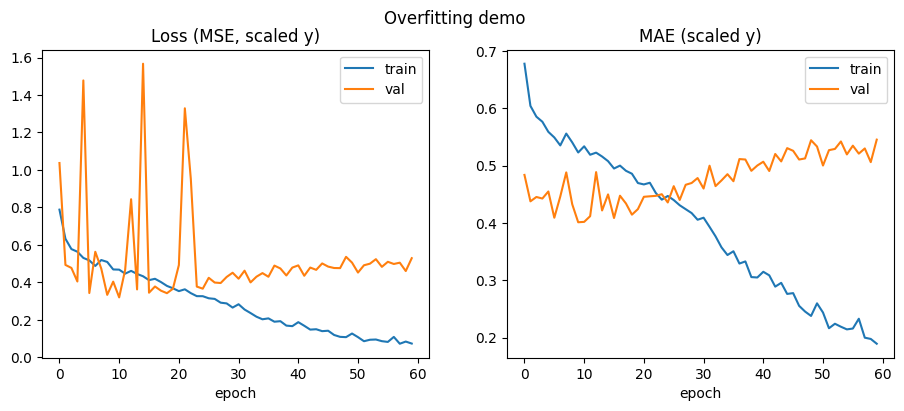

In [21]:
def plot_history(h, title="History"):
    plt.figure(figsize=(11,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(h.history["loss"], label="train")
    plt.plot(h.history["val_loss"], label="val")
    plt.title("Loss (MSE, scaled y)"); plt.xlabel("epoch"); plt.legend()
    # MAE
    plt.subplot(1,2,2)
    plt.plot(h.history["mae"], label="train")
    plt.plot(h.history["val_mae"], label="val")
    plt.title("MAE (scaled y)"); plt.xlabel("epoch"); plt.legend()
    plt.suptitle(title)
    plt.show()

plot_history(history, "Overfitting demo")


# Reset model

In [22]:
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(1024, activation="relu"),
    layers.Dense(1024, activation="relu"),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(1, activation=None),  # linear output for regression
], name="overfit_ann")

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="mse", metrics=["mae"])
model.summary()


Model: "overfit_ann"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 1024)           │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,715,201 (6.54 MB)

 Trainable params: 1,715,201 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.8535 - mae: 0.7111 - val_loss: 1.1515 - val_mae: 0.5317
Epoch 2/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6878 - mae: 0.6289 - val_loss: 0.9284 - val_mae: 0.4639
Epoch 3/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5661 - mae: 0.5678 - val_loss: 1.5700 - val_mae: 0.4426
Epoch 4/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5632 - mae: 0.5620 - val_loss: 1.0310 - val_mae: 0.4567
Epoch 5/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5570 - mae: 0.5645 - val_loss: 1.0064 - val_mae: 0.4605
Epoch 6/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4934 - mae: 0.5468 - val_loss: 0.4119 - val_mae: 0.4069
Epoch 7/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5038 - mae: 0.5436 - val_loss: 0.3227 - val_mae: 0.4092
Epoch 8/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3959 - mae: 0.4885 - val_loss: 0.3448 - val_mae: 0.4033
Epoch 9/60
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4919 - 

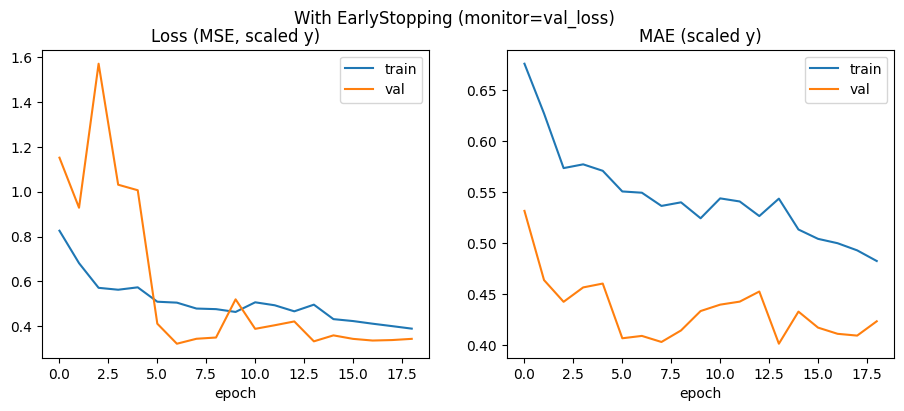

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=12,          # ปรับได้: 8–20 แล้วแต่ความแกว่งของ val
    min_delta=0.0,        # ตั้ง >0 ถ้าอยากให้ "ดีขึ้นอย่างมีนัย"
    restore_best_weights=True,
    verbose=1
)

history_es = model.fit(
    X_train, y_train_s_noisy,         # ใช้ชุด train ที่ใส่ noise ไว้
    validation_data=(X_val, y_val_s),
    epochs=60,                       # ตั้งเยอะไว้ได้ เพราะ ES จะหยุดให้เอง
    batch_size=16,                    # เหมือนที่ใช้เดิม
    callbacks=[es],
    verbose=1
)

# ถ้ามีฟังก์ชัน plot_history จากก่อนหน้า:
plot_history(history_es, "With EarlyStopping (monitor=val_loss)")
